In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  # for plotting images, spectra, and metrics
from scipy.fft import fft2, fftshift  # for frequency-domain transforms

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

import shutil  # only if you need to move/copy datasets


In [3]:
# Base path to your dataset
BASE_PATH = '/cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake'

train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'valid')
test_dir = os.path.join(BASE_PATH, 'test')

# Check paths
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

Training directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/train
Validation directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/valid
Test directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/test


In [4]:
# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=32,
    image_size=(128, 128)  # matches your FFT preprocessing
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=32,
    image_size=(128, 128)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=False,  # usually don't shuffle test data
    batch_size=32,
    image_size=(128, 128)
)

Found 100001 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20001 files belonging to 2 classes.


In [5]:
def standardize_image(image, label):
    """
    Converts an image to grayscale and normalizes its pixel values to [0, 1].
    """
    # Convert image to grayscale
    image = tf.image.rgb_to_grayscale(image)
    
    # Normalize pixel values to the [0, 1] range
    image = image / 255.0 
    
    return image, label

In [6]:
# Use AUTOTUNE to allow TensorFlow to find the best parallel settings
AUTOTUNE = tf.data.AUTOTUNE

# Apply the standardization function to each dataset
train_std = train_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_std = val_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)
test_std = test_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)

# Configure datasets for optimal performance
train_std = train_std.cache().prefetch(buffer_size=AUTOTUNE)
val_std = val_std.cache().prefetch(buffer_size=AUTOTUNE)
test_std = test_std.cache().prefetch(buffer_size=AUTOTUNE)

print("Standardization applied successfully.")

Standardization applied successfully.


\n--- Verifying a batch of standardized images ---
Shape of image batch: (32, 128, 128, 1)
Minimum pixel value: 0.0
Maximum pixel value: 0.99990004


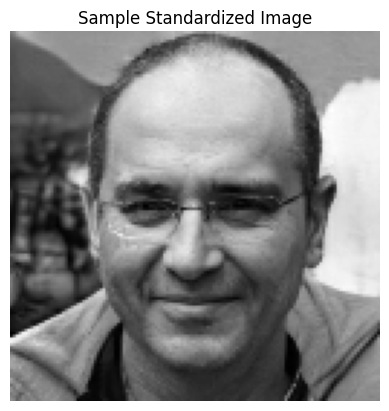

In [7]:
for images, labels in train_std.take(1):
    print("\\n--- Verifying a batch of standardized images ---")
    
    # Check the shape: The last dimension should now be 1 (for grayscale)
    print("Shape of image batch:", images.shape) 
    
    # Check the data range: Values should be between 0 and 1
    print("Minimum pixel value:", tf.reduce_min(images).numpy())
    print("Maximum pixel value:", tf.reduce_max(images).numpy())
    
    # Display the first image in the batch
    plt.imshow(images[0], cmap='gray')
    plt.title("Sample Standardized Image")
    plt.axis('off')
    plt.show()

In [8]:
# Create smaller subsets for faster development
SUBSET_BATCHES = 20 # 20 batches * 32 images/batch = 640 images
train_subset = train_dataset.take(SUBSET_BATCHES)
val_subset = val_dataset.take(SUBSET_BATCHES)

print(f"Created a training subset with {SUBSET_BATCHES} batches.")

Created a training subset with 20 batches.


In [9]:
def transform_to_fft(images):
    """
    Takes a batch of standardized images and returns their 2D log-magnitude spectra.
    """
    fft_images = []
    for img in images.numpy(): # Convert tensor to numpy to use scipy
        # Remove the channel dimension for 2D FFT
        img_squeezed = np.squeeze(img, axis=-1)

        # Apply 2D FFT and shift the zero-frequency component to the center
        fft = fft2(img_squeezed)
        fft_shifted = fftshift(fft)

        # Calculate the log-magnitude spectrum
        magnitude_spectrum = np.log(np.abs(fft_shifted) + 1)

        # Add the channel dimension back for consistency
        fft_images.append(np.expand_dims(magnitude_spectrum, axis=-1))

    return np.array(fft_images, dtype=np.float32)

def fft_wrapper(image, label):
    """A TensorFlow wrapper for the FFT function."""
    fft_image = tf.py_function(
        func=transform_to_fft,
        inp=[image],
        Tout=tf.float32
    )
    fft_image.set_shape([None, 128, 128, 1])
    return fft_image, label

Shape of FFT image batch: (32, 128, 128, 1)


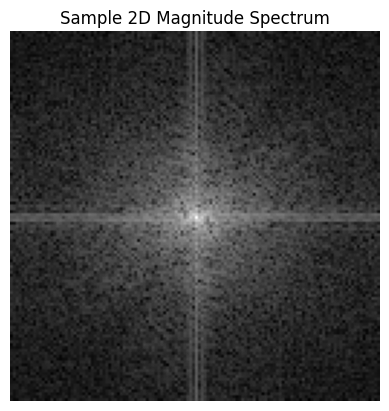

In [10]:
# Apply the FFT transformation to your standardized subset
train_fft = train_std.map(fft_wrapper, num_parallel_calls=AUTOTUNE)

# --- Verify the Output ---
for images_fft, labels in train_fft.take(1):
    print("Shape of FFT image batch:", images_fft.shape)

    # Display the first FFT spectrum in the batch
    plt.imshow(images_fft[0], cmap='gray')
    plt.title("Sample 2D Magnitude Spectrum")
    plt.axis('off')
    plt.show()

In [11]:
def azimuthal_average(spectrum):
    """Calculates the azimuthally averaged 1D profile of a 2D spectrum."""
    center_y, center_x = np.array(spectrum.shape) // 2
    y, x = np.indices(spectrum.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2).astype(int)
    tbin = np.bincount(r.ravel(), weights=spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = np.divide(tbin, nr, out=np.zeros_like(tbin, dtype=float), where=nr!=0)
    return radial_profile

def process_to_1d_profile(images_fft):
    """Takes a batch of 2D spectra and returns their 1D profiles."""
    profiles = []
    for spectrum in images_fft.numpy():
        profile = azimuthal_average(np.squeeze(spectrum, axis=-1))

        # Pad or truncate the profile to a fixed length for the model.
        fixed_length = 91
        if len(profile) < fixed_length:
            profile = np.pad(profile, (0, fixed_length - len(profile)))
        else:
            profile = profile[:fixed_length]
        profiles.append(profile)
    return np.array(profiles, dtype=np.float32)

def profile_wrapper(image_fft, label):
    """TensorFlow wrapper for the 1D profile function."""
    profile = tf.py_function(
        func=process_to_1d_profile,
        inp=[image_fft],
        Tout=tf.float32
    )
    profile.set_shape([None, 91])
    return profile, label

Shape of final feature batch: (32, 91)


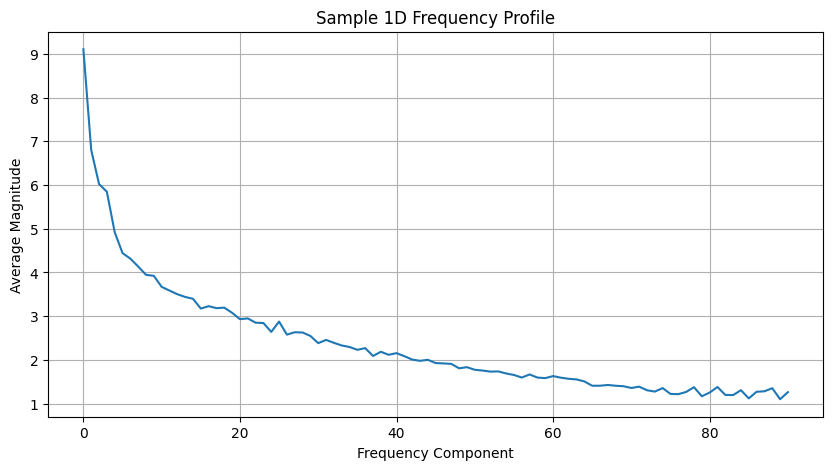

In [12]:
# Apply the final transformation to get 1D profiles
train_processed = train_fft.map(profile_wrapper, num_parallel_calls=AUTOTUNE)

# --- Verify the Final Output ---
for features, labels in train_processed.take(1):
    print("Shape of final feature batch:", features.shape)

    # Plot the first feature vector in the batch
    plt.figure(figsize=(10, 5))
    plt.plot(features[0])
    plt.title("Sample 1D Frequency Profile")
    plt.xlabel("Frequency Component")
    plt.ylabel("Average Magnitude")
    plt.grid(True)
    plt.show()

In [14]:
# 1. Define the MLP model architecture
model = Sequential([
    # Input layer: The shape must match your 1D frequency profile length (91)
    Dense(128, activation='relu', input_shape=(91,)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output layer: A single neuron with a sigmoid activation for binary classification
    Dense(1, activation='sigmoid') 
])

# 2. Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)

# Print a summary of the model to check it
model.summary()

# 3. Train the model on your processed subset data
# Note: Since you're using a small subset, training will be very fast.
# We'll use the validation data we created earlier as well.
val_processed = val_std.map(fft_wrapper, num_parallel_calls=AUTOTUNE)
val_processed = val_processed.map(profile_wrapper, num_parallel_calls=AUTOTUNE)

history = model.fit(
    train_processed,
    validation_data=val_processed,
    epochs=30 # We can train for a few epochs to see it work
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,097 (78.50 KB)

 Trainable params: 20,097 (78.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 0.5378 - loss: 0.7005 - val_accuracy: 0.5780 - val_loss: 0.6801
Epoch 2/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 77s 24ms/step - accuracy: 0.5659 - loss: 0.6811 - val_accuracy: 0.5853 - val_loss: 0.6762
Epoch 3/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 77s 25ms/step - accuracy: 0.5760 - loss: 0.6785 - val_accuracy: 0.5850 - val_loss: 0.6748
Epoch 4/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 75s 24ms/step - accuracy: 0.5778 - loss: 0.6773 - val_accuracy: 0.5882 - val_loss: 0.6752
Epoch 5/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.5783 - loss: 0.6771 - val_accuracy: 0.5870 - val_loss: 0.6738
Epoch 6/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.5802 - loss: 0.6767 - val_accuracy: 0.5871 - val_loss: 0.6732
Epoch 7/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.5805 - loss: 0.6763 - val_accuracy: 0.5868 - val_loss: 0.6729
Epoch 8/30
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.5817 -

In [20]:
test_processed = test_std.map(fft_wrapper, num_parallel_calls=AUTOTUNE)
test_processed = test_processed.map(profile_wrapper, num_parallel_calls=AUTOTUNE)
loss, accuracy = model.evaluate(test_processed)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.6272 - loss: 0.6522
Test Loss: 0.6701
Test Accuracy: 0.5918
